In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import time
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



Load the database

In [2]:
dataset = pd.read_csv('../creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Il dataset contiene 284807 transazioni effettuate da carte di credito nel settembre 2013.

Il dataset è estremamente sbilanciato in quanto sono presenti 492 frodi (0.172%) sulle 284807 transazioni totali.

Le feature V1, ..., V28 sono le principal components ottenuta da una PCA; la feature Time contiene i secondi trascorsi tra ciascuna transazione e la prima transazione del dataset; la feature Amount indica l'importo della transazione; infine la feature Class vale 1 se tale transazione è una frode e 0 altrimenti.

In [3]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
dataset.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
dataset.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [6]:
dataset.count()

Time      284807
V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
V6        284807
V7        284807
V8        284807
V9        284807
V10       284807
V11       284807
V12       284807
V13       284807
V14       284807
V15       284807
V16       284807
V17       284807
V18       284807
V19       284807
V20       284807
V21       284807
V22       284807
V23       284807
V24       284807
V25       284807
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
dtype: int64

In [7]:
print('No Frauds', round(dataset['Class'].value_counts()[0]/len(dataset) * 100,2), '% of the dataset')
print('Frauds', round(dataset['Class'].value_counts()[1]/len(dataset) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


La maggior parte delle transazioni sono non frodi. Se usassimo questo database come base per realizzare dei modelli predittivi potremmo ottenere errori ed algoritmi a rischio overfit: essi potrebbero infatti assumere che la maggior parte delle transazioni non sono frodi.

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

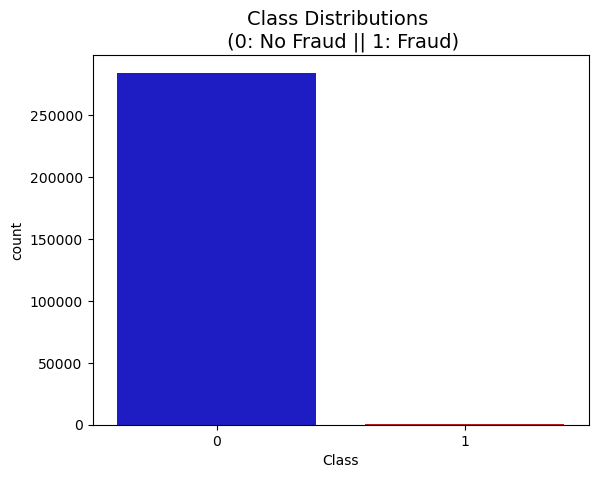

In [8]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=dataset, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)


In [9]:
# rimozione dei duplicati dal dataset
dataset = dataset.drop_duplicates()
dataset.count()

Time      283726
V1        283726
V2        283726
V3        283726
V4        283726
V5        283726
V6        283726
V7        283726
V8        283726
V9        283726
V10       283726
V11       283726
V12       283726
V13       283726
V14       283726
V15       283726
V16       283726
V17       283726
V18       283726
V19       283726
V20       283726
V21       283726
V22       283726
V23       283726
V24       283726
V25       283726
V26       283726
V27       283726
V28       283726
Amount    283726
Class     283726
dtype: int64

In [10]:
# non sono presenti valori mancanti, nulli.
dataset.isnull().values.sum()

0

Visualizzazione della distribuzione delle osservazioni del dataset

Boxplot

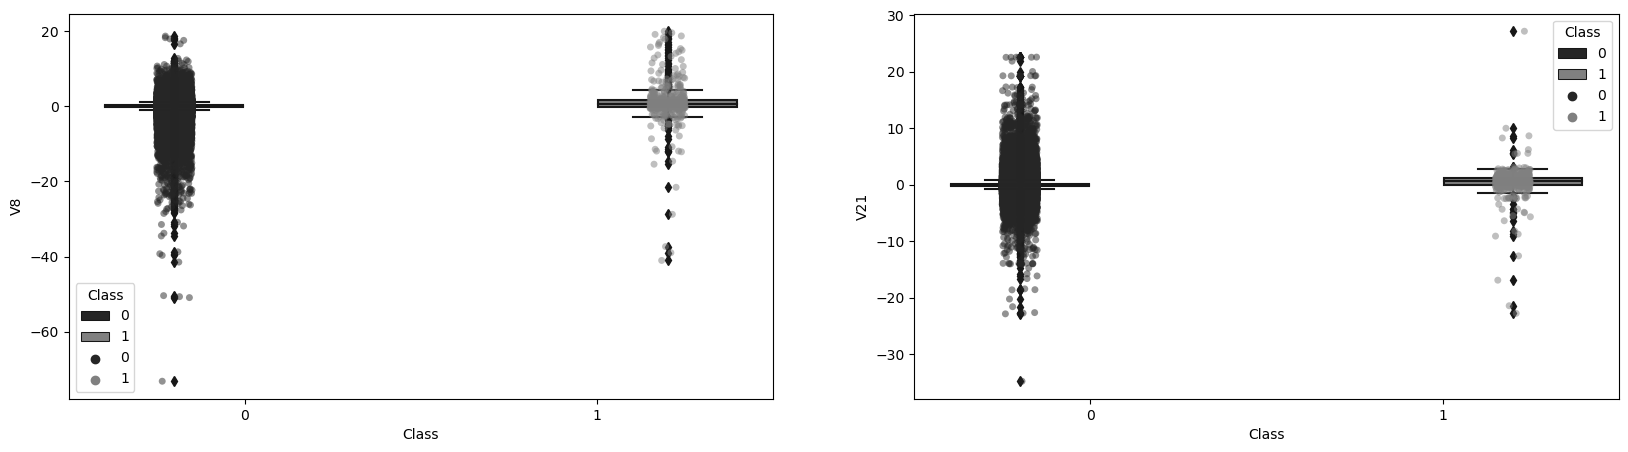

In [11]:
#è possibile osservare come per le features V8 e V21 la mediana è in un intorno del valor medio,
# con pochi outliers, soprattutto per valori negativi della feature

cols = ['V8', 'V21']
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
for index,col in enumerate(cols):
    sns.boxplot(x="Class", y=col, hue="Class", palette='dark:grey', data=dataset, ax=axes[index]) 
    sns.stripplot(x='Class', y=col,  data=dataset,dodge=True,jitter=True,marker='o',ax=axes[index],alpha=0.5,color='grey',hue='Class')
plt.show()
plt.clf()
plt.close()

Istogrammi

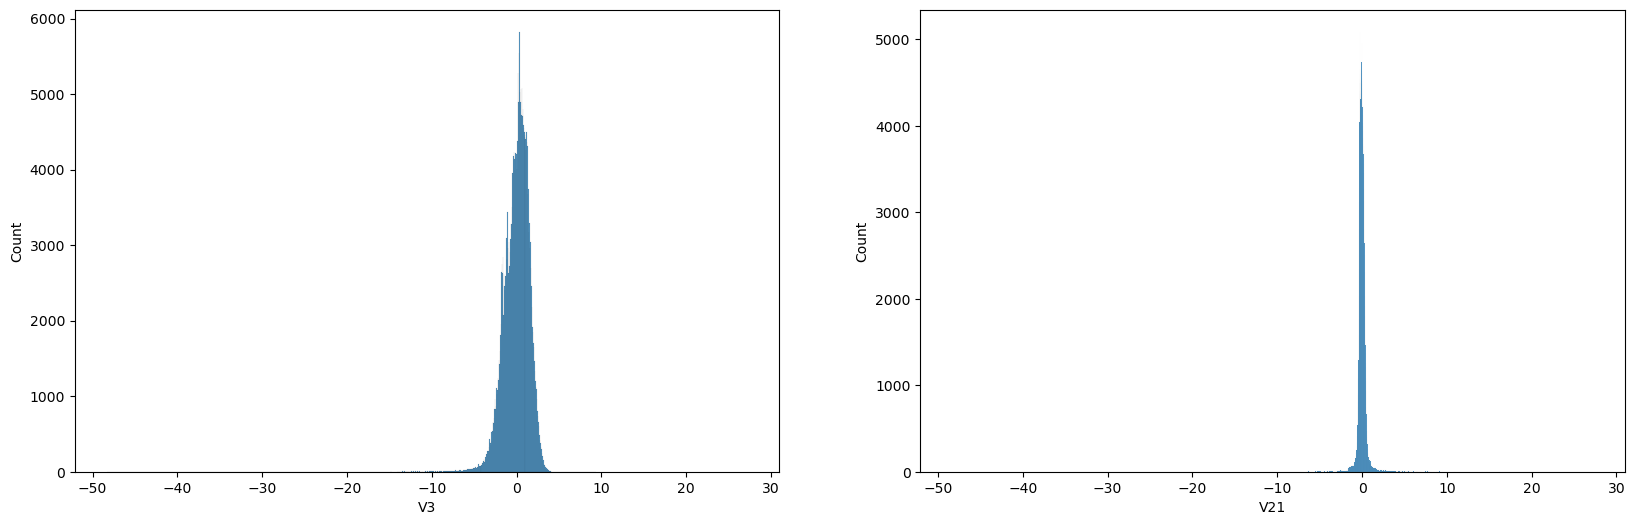

In [12]:
# i seguenti istogrammi mostrano come le osservazioni siano quasi tutte in un intorno del valor medio
# (qui circa 0 per le feature V3 e V21); è però evidente come le osservazioni della feature V3 hanno
# una varianza maggiore rispetto a quelle della feature V21.
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.histplot(dataset['V3'],ax=axes[0])
sns.histplot(dataset['V21'],ax=axes[1])

plt.show()
plt.clf()
plt.close()

Per confrontare le distribuzioni di più di una variabile alla volta (ed individuare eventuali correlazioni) è possibile utilizzare i pair plots, una combinazione di istogrammi e scatter plots.

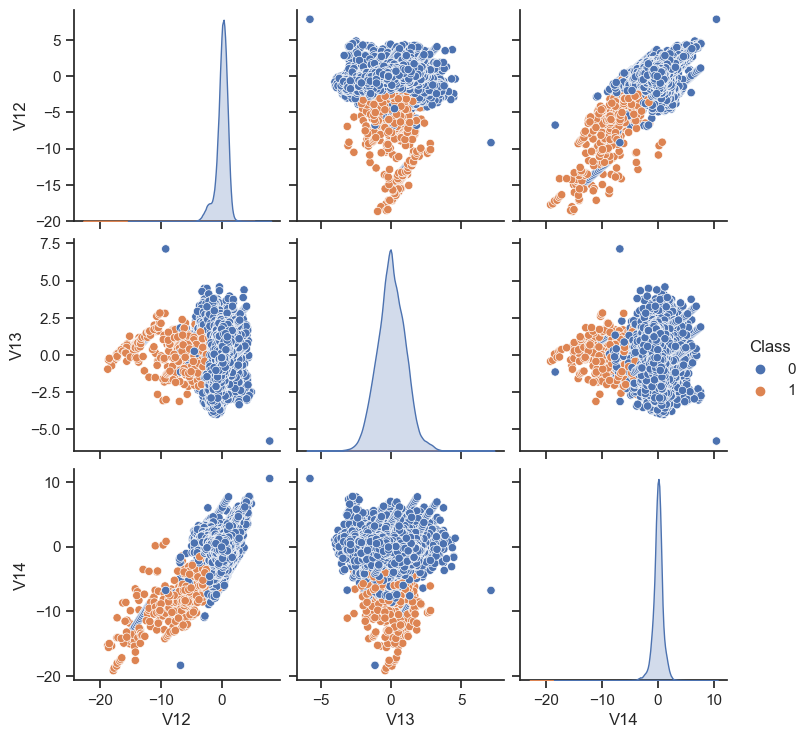

In [13]:
# dalla matrice seguente è possibile osservare come tutte le osservazioni delle 3 feature siano
# concentrate in un intorno del valor medio (ossia il valor 0). 
# Tra queste 3 feature sembra non esserci correlazione, 
# suggerendo come possano essere usate tutte e 3 in un successivo classificatore
sns.set_theme(style="ticks")
sns.pairplot(dataset[["V12","V13","V14","Class"]], hue="Class")

Per poter analizzare la correlazione tra tutte le feature, è utile realizzare una matrice di correlazione
È utilizzata la correlazione di Pearson. Essendo le features V1-V28 ottenute eseguendo una PCA sul dataset originale esse sono totalmente scorrelate.

            Time        V1        V2        V3        V4        V5        V6  \
Time    1.000000  0.117927 -0.010556 -0.422054 -0.105845  0.173223 -0.063279   
V1      0.117927  1.000000  0.006875 -0.008112  0.002257 -0.007036  0.000413   
V2     -0.010556  0.006875  1.000000  0.005278 -0.001495  0.005210 -0.000594   
V3     -0.422054 -0.008112  0.005278  1.000000  0.002829 -0.006879 -0.001511   
V4     -0.105845  0.002257 -0.001495  0.002829  1.000000  0.001744 -0.000880   
V5      0.173223 -0.007036  0.005210 -0.006879  0.001744  1.000000 -0.000938   
V6     -0.063279  0.000413 -0.000594 -0.001511 -0.000880 -0.000938  1.000000   
V7      0.085335 -0.009173  0.007425 -0.011721  0.004657 -0.008709  0.000436   
V8     -0.038203 -0.001168  0.002899 -0.001815  0.000890  0.001430  0.003036   
V9     -0.007861  0.001828 -0.000274 -0.003579  0.002154 -0.001213 -0.000734   
V10     0.031068  0.000815  0.000620 -0.009632  0.002753 -0.006050 -0.002180   
V11    -0.248536  0.001028 -0.000633  0.

<Axes: >

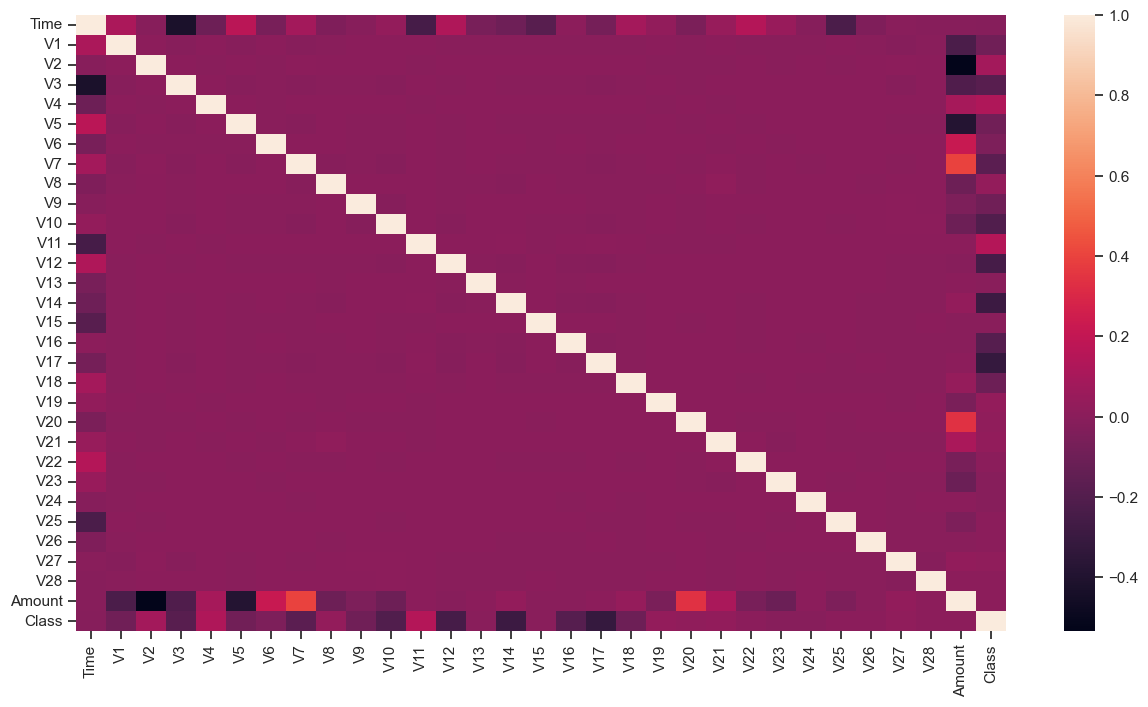

In [14]:
f, ax = plt.subplots(figsize=(15, 8))
corr = dataset.corr()
print(corr)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Tale matrice mostra come non ci sia affatto correlazione tra le features V1-V28. Un moderato livello di correlazione può però essere identificato tra le seguenti coppie di feature: "V3-Time" (-0.42),"V3-Amount" (-0.21),"V2-Amount" (-0.53),"V7-Amount" (0.4),"V20-Amount" (0.34).
Analizziamo più nel dettaglio le correlazioni tra tali coppie di feature con un pair plot.

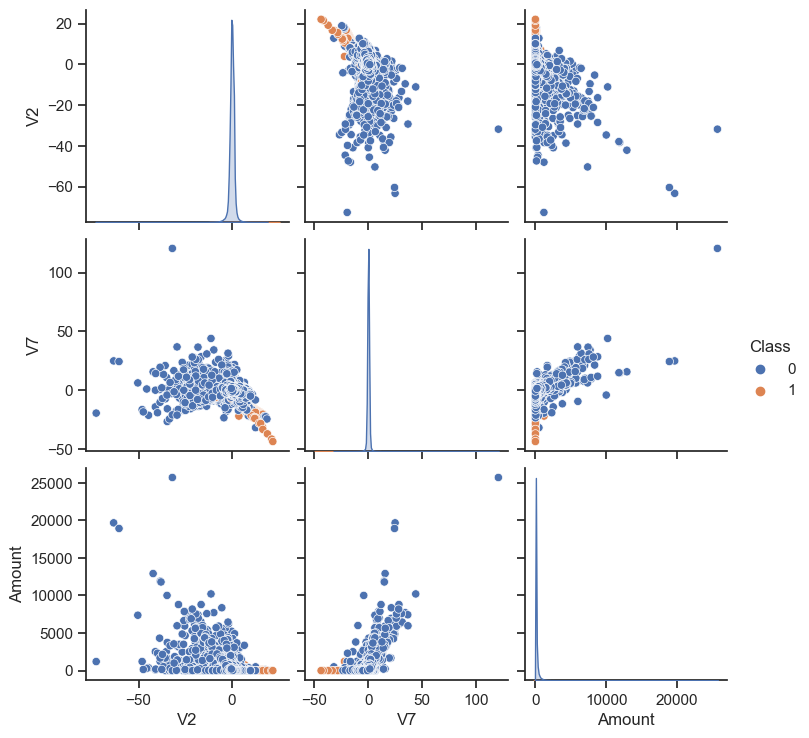

In [15]:
sns.set_theme(style="ticks")
sns.pairplot(dataset[["V2","V7","Amount","Class"]], hue="Class")

Si nota infatti una leggera correlazione tra le coppie di feature "V7-Amount" e "V2-Amount" che però non è così grave ai fini del corretto funzionamento di un successivo classificatore.

Nota: una perfetta correlazione implicherebbe che i punti dei singoli grafici formino una linea perfetta.

A che ora del giorno le persone eseguono degli acquisti?

È utile visualizzare quando avvengono le frodi e se sono presenti eventuali pattern.
Per fare ciò è necessario convertire il tempo da secondi a giorni/ore/settimane.

In [16]:
# Il tempo è fornito in secondi trascorsi dalla prima transazione, perciò possiamo non considerare gli anni
def convert_totime(seconds):
    return datetime.datetime.fromtimestamp(seconds);

timeAnalysis = dataset[['Time', 'Amount', 'Class']].copy()
timeAnalysis['datetime'] = timeAnalysis.Time.apply(convert_totime)
# Poichè il tempo massimo è 172792 secondi che corrisponde a circa 48 ore: 172792 / (60*60)
# graficare i dati ora per ora è utile 
timeAnalysis['hour of the day'] = timeAnalysis.datetime.dt.hour
timeAnalysisGrouped = timeAnalysis.groupby(['Class', 'hour of the day'])['Amount'].count()

<Axes: title={'center': '# of legitimate credit card transactions per hour'}, xlabel='hour of the day'>

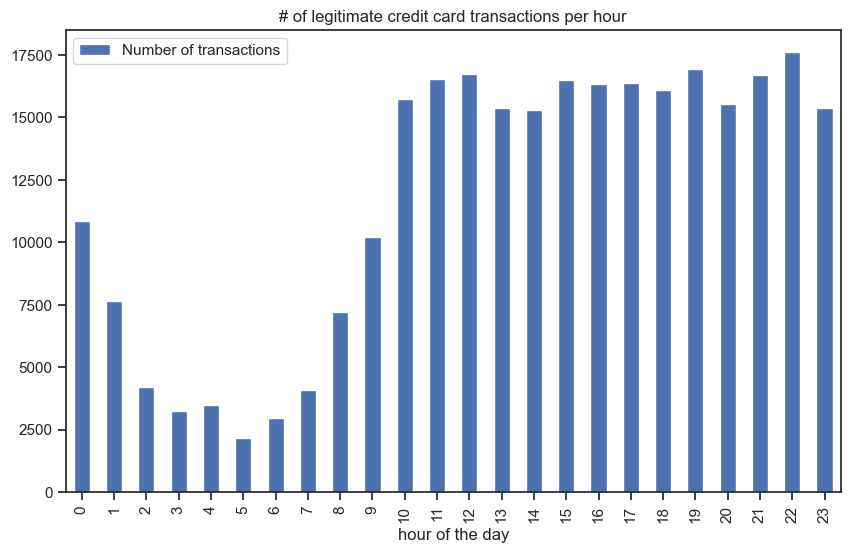

In [17]:
plt.figure(figsize = (10, 6))
validTransactions = timeAnalysisGrouped[0].copy()
validTransactions.name = 'Number of transactions'
validTransactions.plot.bar(title = '# of legitimate credit card transactions per hour', legend = True)

È interessante osservare come la maggior parte delle transazioni avvengano ragionevolmente nell'intervallo 10-23 e solo una minor parte nelle ore 0-9.

<Axes: title={'center': '# of fraud credit card transactions per hour'}, xlabel='hour of the day'>

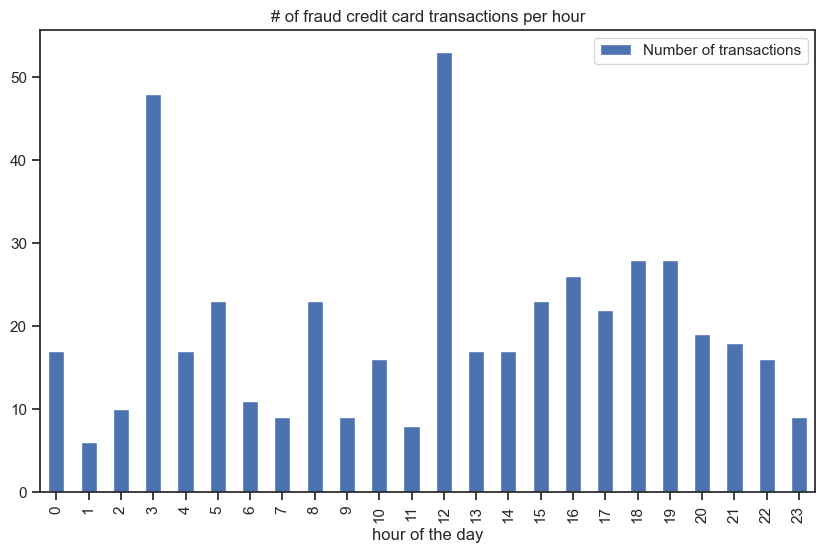

In [18]:
plt.figure(figsize = (10, 6))
fraudTransactions = timeAnalysisGrouped[1].copy()
fraudTransactions.name = 'Number of transactions'
fraudTransactions.plot.bar(title = '# of fraud credit card transactions per hour', legend = True)

È interessante osservare come le transazioni fraudolente siano meglio distribuite nel tempo rispetto a quelle legittime, ad eccezione di alcuni picchi (es 2 AM). Tali picchi possono essere causati dalla presenza di poche transazioni fraudolente nel dataset, rendendo impossibile individuare un trend come per le transazioni legittime.

Le transazioni fraudolente hanno importo maggiore rispetto alle transazioni normali?

Per verificare tale ipotesi si può costruire un test d'ipotesi:

-H0 (ipotesi nulla): le transazioni fraudolente hanno valore minore o uguale a quelle normali (AmountFraud<=AmountNormal);

-HA: le transazioni fraudolente hanno valore maggiore di quelle normali (AmountFraud>AmountNormal).

<Axes: title={'center': 'Histogram of valid transactions'}, ylabel='Frequency'>

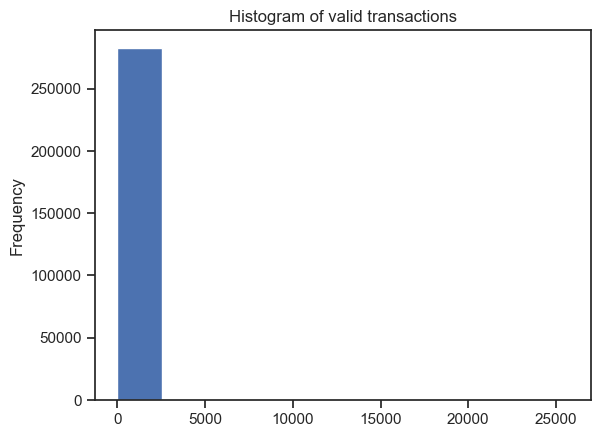

In [19]:
# Valid Transactions
timeAnalysis[timeAnalysis.Class == 0].Amount.plot.hist(title = 'Histogram of valid transactions')

<Axes: title={'center': 'Histogram of valid transactions (Amount <= 4K)'}, ylabel='Frequency'>

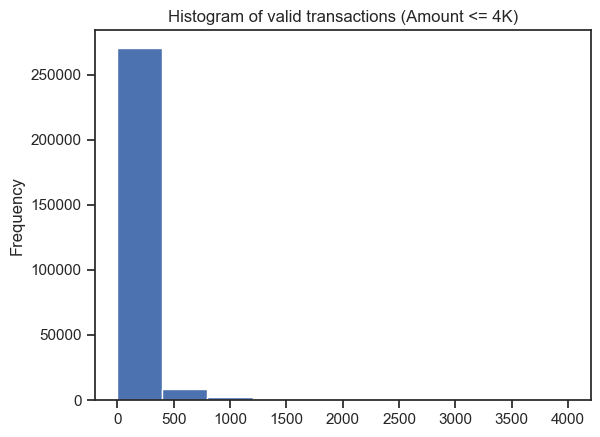

In [20]:
# il valore della maggior parte delle transazioni sembra essere tra 2000 e 2500.
# è utile analizzare tale intervallo di osservazioni più in dettaglio
timeAnalysis[(timeAnalysis.Class == 0) & (timeAnalysis.Amount <= 4000)].Amount.plot.hist(title = 'Histogram of valid transactions (Amount <= 4K)')

<Axes: title={'center': 'Histogram of fraudulent transactions'}, ylabel='Frequency'>

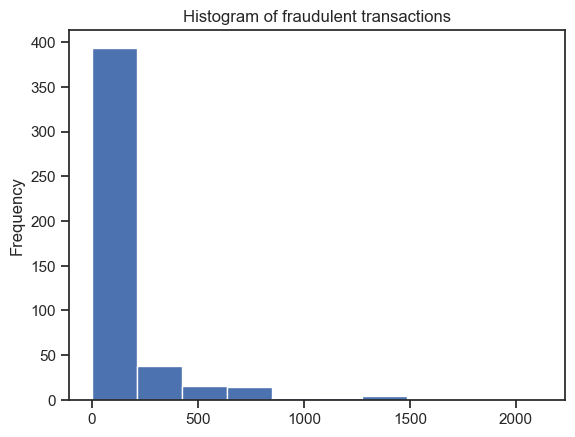

In [21]:
# per le transazioni fraudolente
timeAnalysis[timeAnalysis.Class == 1].Amount.plot.hist(title = 'Histogram of fraudulent transactions')

Visivamente non sembrerebbe emergere alcuna differenza: verifichiamo col test d'ipotesi.


Utilizziamo un livello di significatività del 99% e calcoliamo la statistica del test.
Come stimatore per la media della popolazione (tx normali) usiamo la media campionaria (tx fraudolenti).

$$
\text{z-score} = \frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}}
$$
$$
\bar{x}: \text{media campionaria (tx fraudolenti)}
$$
$$
\mu: \text{media della popolazione (tx normali)}
$$
$$
\sigma: \text{deviazione standard della popolazione (tx normali)}
$$
$$
\text{n}: \text{taglia del campione (tx fraudolenti)}
$$


In [22]:
population = timeAnalysis[timeAnalysis.Class == 0].Amount
sample = timeAnalysis[timeAnalysis.Class == 1].Amount
sampleMean = sample.mean()
populationStd = population.std()
populationMean = population.mean()

In [23]:
z_score = (sampleMean - populationMean) / (populationStd / sample.size ** 0.5)
print(f"z-score = {z_score}")

z-score = 3.07999750831394


Dato che la statistica del test è maggiore di 2.33 (il quantile Z(1%)) rifiutiamo l'ipotesi nulla H0. Segue che c'è il 99% di probabilità che l'importo speso in transazioni fraudolente sia maggiore di quello speso in transazioni legittime.

Eseguiamo un test d'ipotesi per ognuna delle 28 feature (V1, ..., V28) per vedere se il valore della feature per transazioni fraudolente è significativamente diverso da quello della transazione normale (se i valori di tale feature sono simili per entrambi i tipi di transazioni essa non è significativa per discernere tra transazioni fraudolente e non).

Utilizziamo sempre un livello di significatività del 99% e rifiutiamo se la statistica del test (ora in valore assoluto) è maggiore del quantile Z(0.5%) ossia 2.58 .

In [24]:
PDA_columns = [x for x in dataset.columns if 'V' in x]

valid_transactions = dataset[dataset.Class == 0]
Fraud_transactions = dataset[dataset.Class == 1]

sample_size = Fraud_transactions.shape[0]
for col in PDA_columns:
    mean = valid_transactions[col].mean()
    std = valid_transactions[col].std()
    zScore = (Fraud_transactions[col].mean() - mean) / (std/sample_size**0.5)
    print ('Column', col, 'is', 'Significant' if abs(zScore) >= 2.58 else 'insignificant')

Column V1 is Significant
Column V2 is Significant
Column V3 is Significant
Column V4 is Significant
Column V5 is Significant
Column V6 is Significant
Column V7 is Significant
Column V8 is Significant
Column V9 is Significant
Column V10 is Significant
Column V11 is Significant
Column V12 is Significant
Column V13 is insignificant
Column V14 is Significant
Column V15 is insignificant
Column V16 is Significant
Column V17 is Significant
Column V18 is Significant
Column V19 is Significant
Column V20 is Significant
Column V21 is Significant
Column V22 is Significant
Column V23 is Significant
Column V24 is Significant
Column V25 is insignificant
Column V26 is insignificant
Column V27 is Significant
Column V28 is Significant


Le feature V13, V15, V22, V23, V25, V26 non sono molto utili per differenziare tra transazioni fraudolente e legittime. Probabilmente rimuovere tali features potrebbe essere utile per costruire classificatori migliori.

Scaling: normalizzazione

Poichè le features V1, ..., V28 sono scalate (a causa della PCA), è necessario scalare anche le colonne Time e Amount.

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
# scalature di time e amount
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

dataset['scaled_amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['scaled_time'] = rob_scaler.fit_transform(dataset['Time'].values.reshape(-1,1))

dataset.drop(['Time','Amount'], axis=1, inplace=True)

In [26]:
scaled_amount = dataset['scaled_amount']
scaled_time = dataset['scaled_time']

dataset.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
dataset.insert(0, 'scaled_amount', scaled_amount)
dataset.insert(1, 'scaled_time', scaled_time)

# Amount e Time sono scalate

dataset.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-0.995290,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,-0.995290,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-0.995279,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.411487,-0.995279,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.667362,-0.995267,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In seguito sarà necessario un sotto campione del dataframe per avere un numero uguale di transazioni fraudolente e non, per migliorare la capacità degli algoritmi di apprendere pattern per classificare le transazioni come legittime o fraudolente.

Usare il database originale, estremamente sbilanciato, potrebbe portare infatti a problemi di:

-overfitting: i modelli di classificazione potrebbero assumere che le transazioni sono in maggior parte legittime ed assumere comportamenti non desiderati

-correlazioni non precise: con un database non bilanciato non si possono vedere le vere relazioni tra le features.

Data splitting

Prima di procedere con la tecnica di Random Under Sampling dobbiamo separare il database originale in training e test set. Per testare i nostri modelli, quando si implementano tecniche di Random Under/Over Sampling, è necessario usare i test set costruiti sui dati originali, e non quelli creati da tali tecniche. 

In [27]:
# tale codice suddivide il dataset in set di addestramento e di test
# utilizzando una cross-validation stratificata per mantenere la distribuzione 
# delle classi bilanciata in ciascuna suddivisione. Dopo la suddivisione, il codice 
# verifica che le distribuzioni delle classi siano simili tra il set di addestramento e quello di test.

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(dataset['Class'].value_counts()[0]/len(dataset) * 100,2), '% of the dataset')
print('Frauds', round(dataset['Class'].value_counts()[1]/len(dataset) * 100,2), '% of the dataset')

X = dataset.drop('Class', axis=1)
y = dataset['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30191  30261  30275 ... 283723 283724 283725] Test: [    0     1     2 ... 56805 56806 56807]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 30191  30261  30275 ... 113535 113536 113537]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 77084  77379  79220 ... 170292 170293 170294]
Train: [     0      1      2 ... 283723 283724 283725] Test: [149302 150027 150068 ... 226999 227000 227001]
Train: [     0      1      2 ... 226999 227000 227001] Test: [212341 212365 213905 ... 283723 283724 283725]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99833466 0.00166534]
[0.99832584 0.00167416]


Random Under-Sampling

Tale tecnica consiste nel rimuovere osservazioni per ottenere un dataset più bilanciato, evitando modelli in overfit.

Noto il numero di transazioni fraudolente (492) si riduce il numero di transazioni legittime (scegliendole in modo randomico, eseguendo uno shuffle) per avere un 50% di transazioni legittime (ossia 492) ed un 50% di transazioni fraudolente (ossia 492).

Il problema principale con questa tecnica è che si corre il rischio di avere modelli di classificazione non accurati come vorremo a causa di una perdita di informazioni causata dalla riduzione delle 284315 transazioni legittime a solo 492.



In [28]:
#crea un nuovo dataset bilanciato tra le classi di frodi e non frodi a partire
#  da un dataset sbilanciato. Prima mescola le righe originali, poi seleziona tutte
#  le righe della classe fraudolenta e un numero uguale di righe della classe non fraudolenta. 
# Dopo averle concatenate, il codice mescola nuovamente il nuovo DataFrame per assicurare 
# che le righe siano in ordine casuale.
# Lets shuffle the data before creating the subsamples

df = dataset.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
200609,-0.304408,0.57360,2.146677,0.179386,-2.358015,0.544016,0.577376,-1.870438,0.953709,-0.620130,...,-0.341254,0.252343,0.876999,-0.164308,0.116830,0.642594,0.724595,-0.130772,-0.095903,0
79525,-0.292032,-0.31298,-2.630598,5.125759,-6.092255,5.527393,1.605145,-2.319884,-3.207076,-1.482583,...,0.948864,-0.527474,0.220546,-1.371110,-0.504899,0.382307,0.395528,0.782036,0.628528,1
77387,5.870811,-0.32512,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,...,0.274027,0.785540,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,1
56703,-0.295369,-0.43655,1.176716,0.557091,-0.490800,0.756424,0.249192,-0.781871,0.228750,-0.040840,...,-0.102772,-0.062166,-0.128168,-0.040176,0.110040,0.437891,0.368809,-0.018287,0.031173,1
248296,-0.305938,0.81302,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,...,0.354773,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1


Le classi nel sotto campione sono in ugual numero

Distribution of the Classes in the subsample dataset
0    0.509845
1    0.490155
Name: Class, dtype: float64


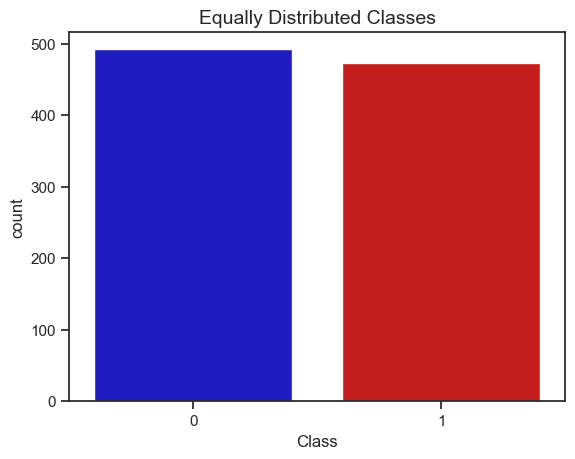

In [29]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

colors1 = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=new_df, palette=colors1)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Matrice di correlazione del sotto campione

L'obiettivo è conoscere quali features influenzano pesantemente il determinare se una specifica transazione è una frode.

Tuttavia, è importante utilizzare il sotto campione per vedere quale feature ha una elevata correlazione (positiva o negativa) con la classe che stabilisce se la transazione è fraudolenta o meno.

Nota: se utilizzassimo il dataset originale per la matrice di correlazione, essa sarebbe influenzata dall'elevata sproporzione tra le due classi.

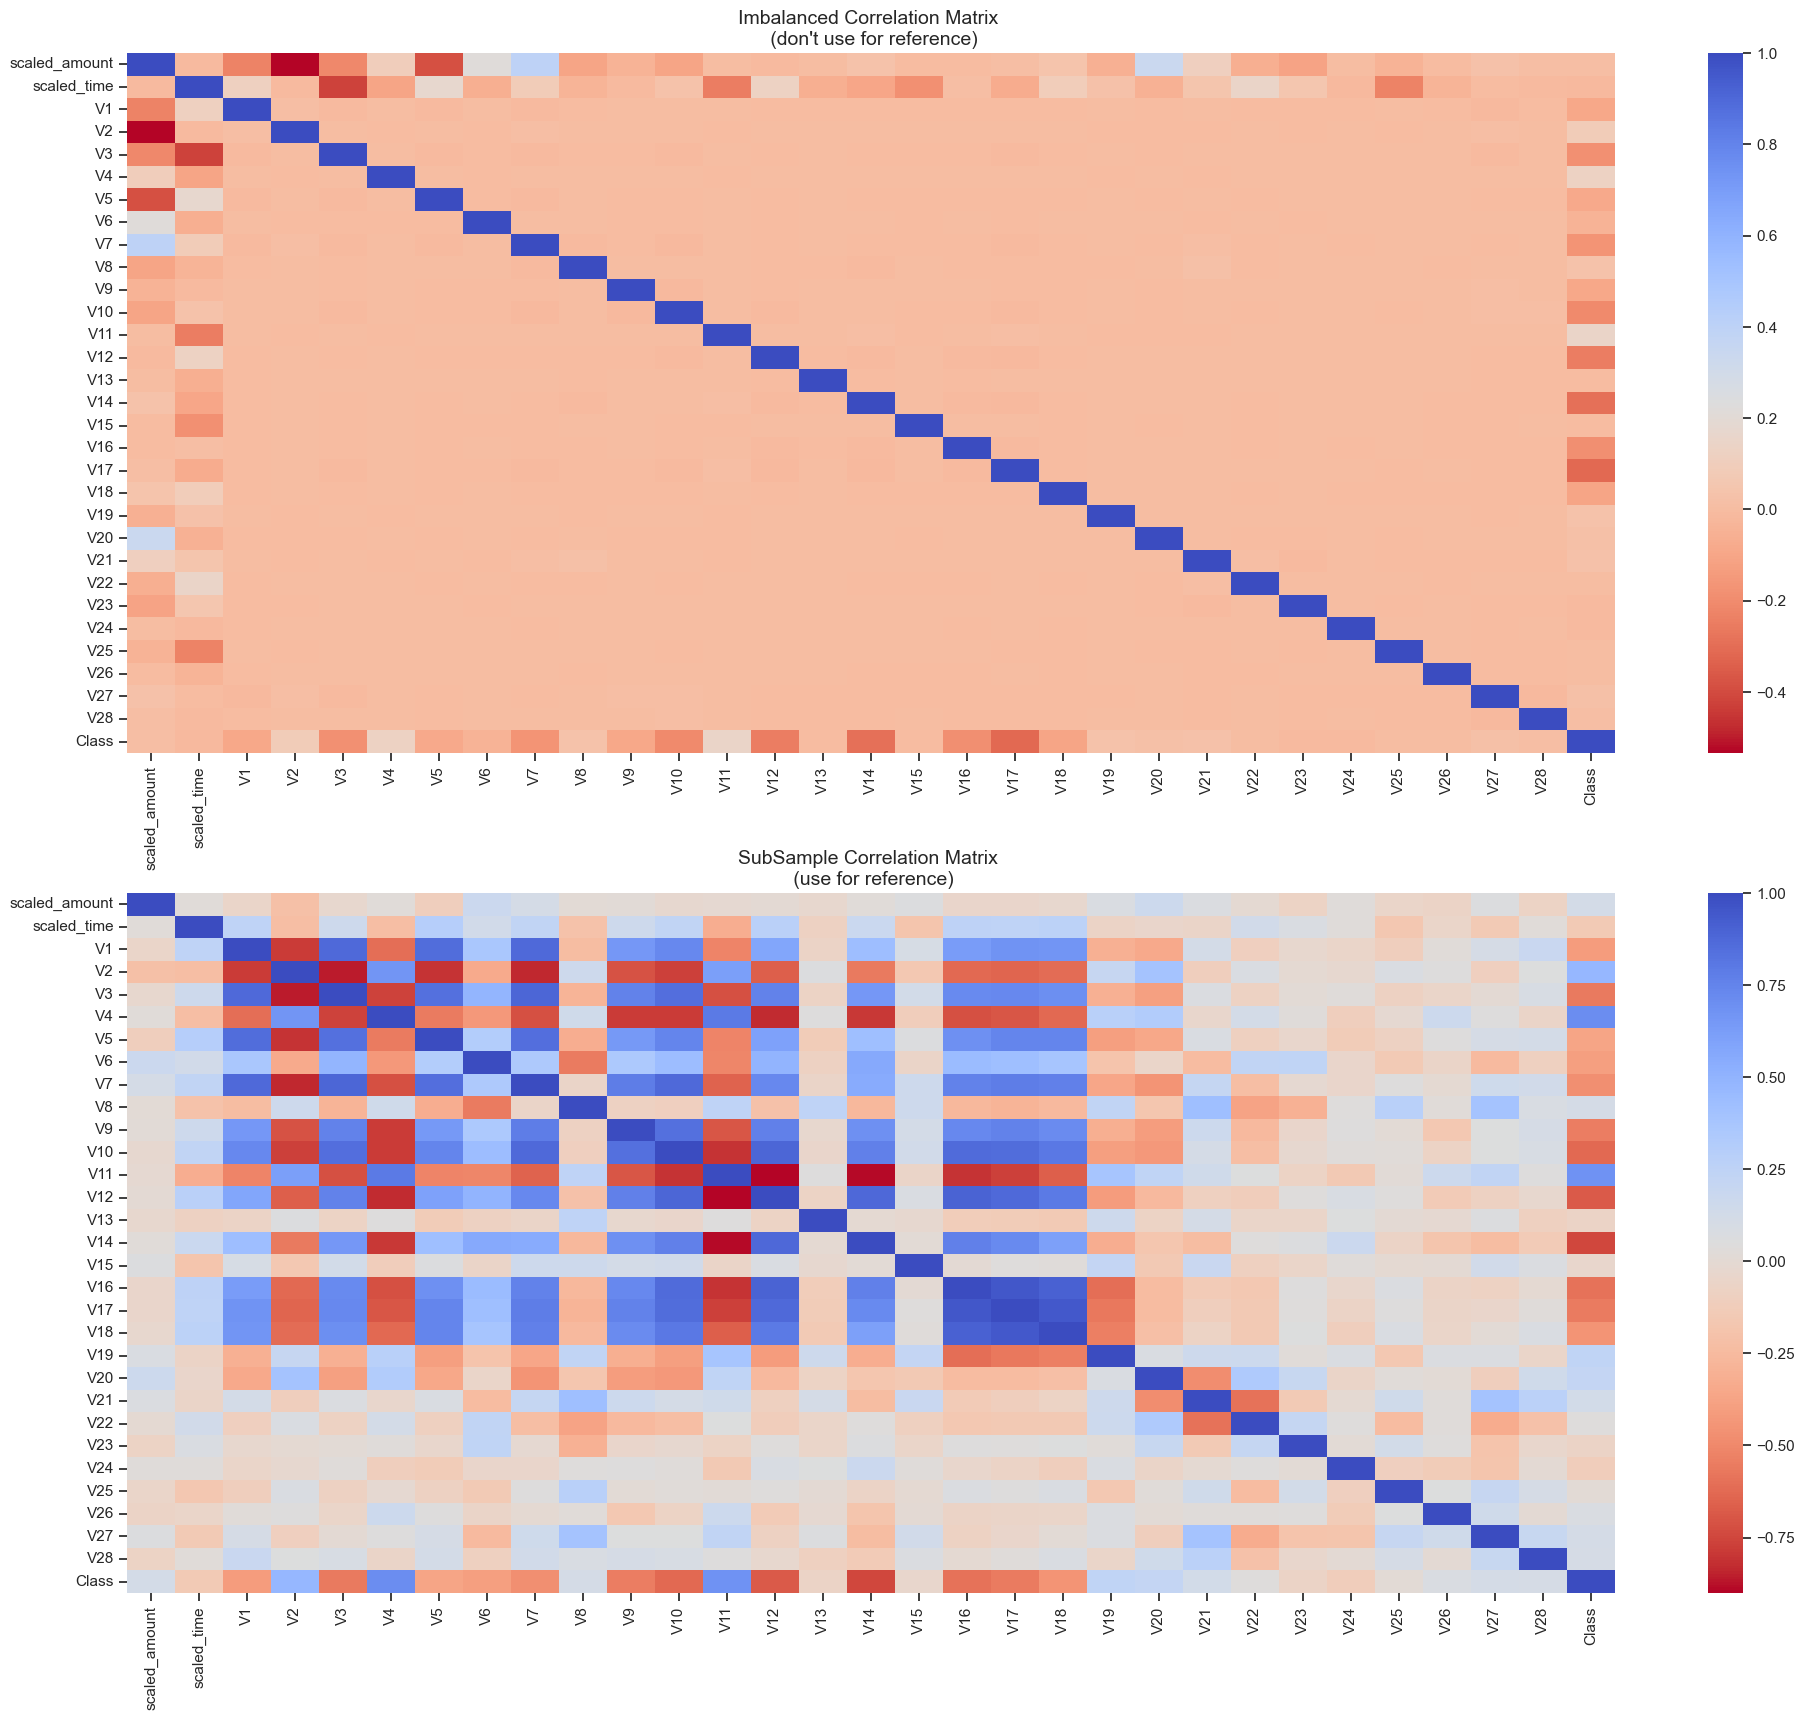

In [30]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

È possibile notare come sia presenta correlazione negativa tra la feature Class e le features V10, V12, V14, V17.
È presente correlazioni positiva tra Class e V2, V4, V11 e V19.

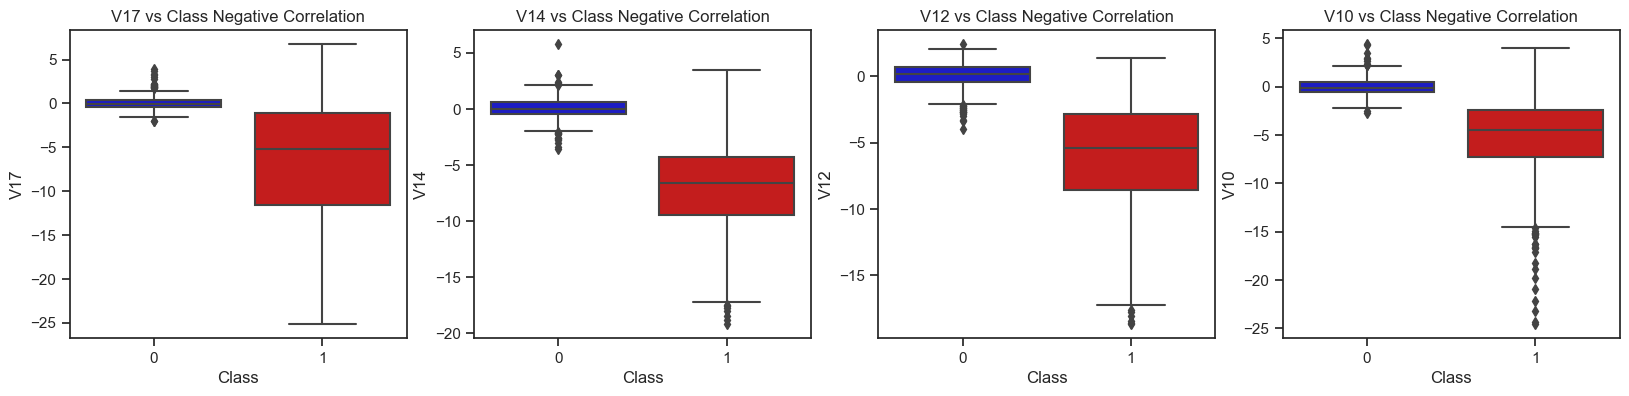

In [31]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

Notare come più le features soprastanti assumono valori bassi e più è probabile che la transazione è fraudolenta.

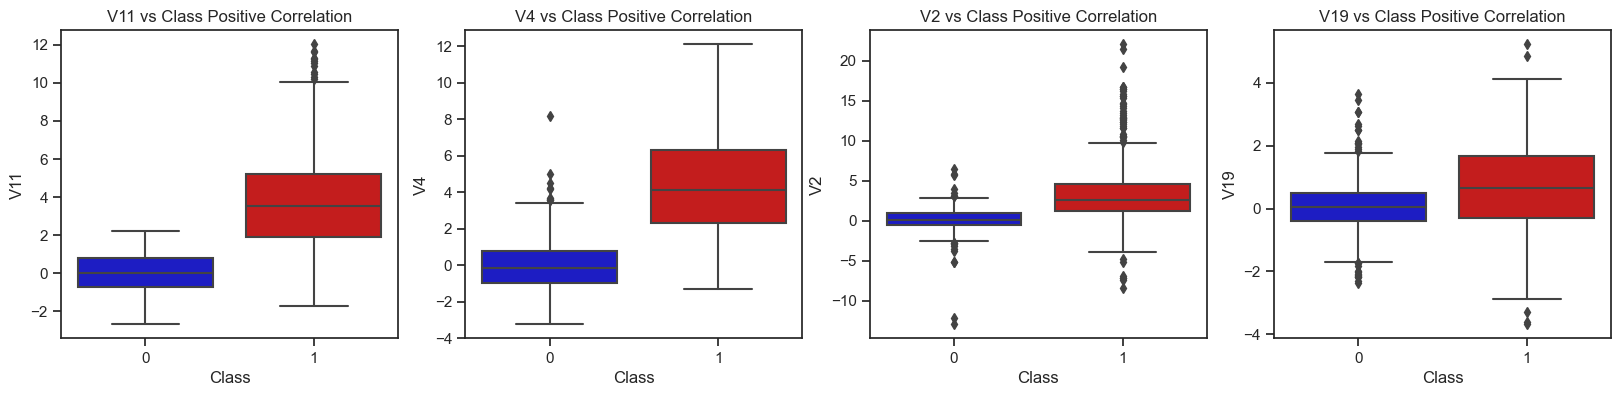

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

Notare come più le features soprastanti assumono valori alti e più è probabile che la transazione è fraudolenta.

Rimozione degli outliers

È spesso utile, per incrementare l'accuracy dei classificatori, rimuovere gli outliers (i valori anomali) dalle features che hanno un'elevata correlazione con le classi.

Il metodo utilizzato è quello dell' "interquartile range" IQR: si effettua la differenza tra il 75 esimo ed il 25 esimo percentile con l'obiettivo di creare una soglia. Tutte le osservazioni che eccedono tale soglia saranno eliminate.

Bisogna prestare attenzione a determinare tale soglia: soglia elevata implica che saranno rilevati e cancellati pochi outliers, rendendo poco utile questo processo. Una soglia bassa, al contrario, potrebbe portare ad eliminare troppe osservazioni, portando ad una perdita di informazione significativa, aumentando il rishio di underfit e riducendo l'accuracy dei modelli.

Visualizzazione delle distribuzioni delle features in base a cui eliminare gli outliers

La feature V14 è l'unica ad avere una distribuzione Gaussiana, a differenza delle features V12 e V10.



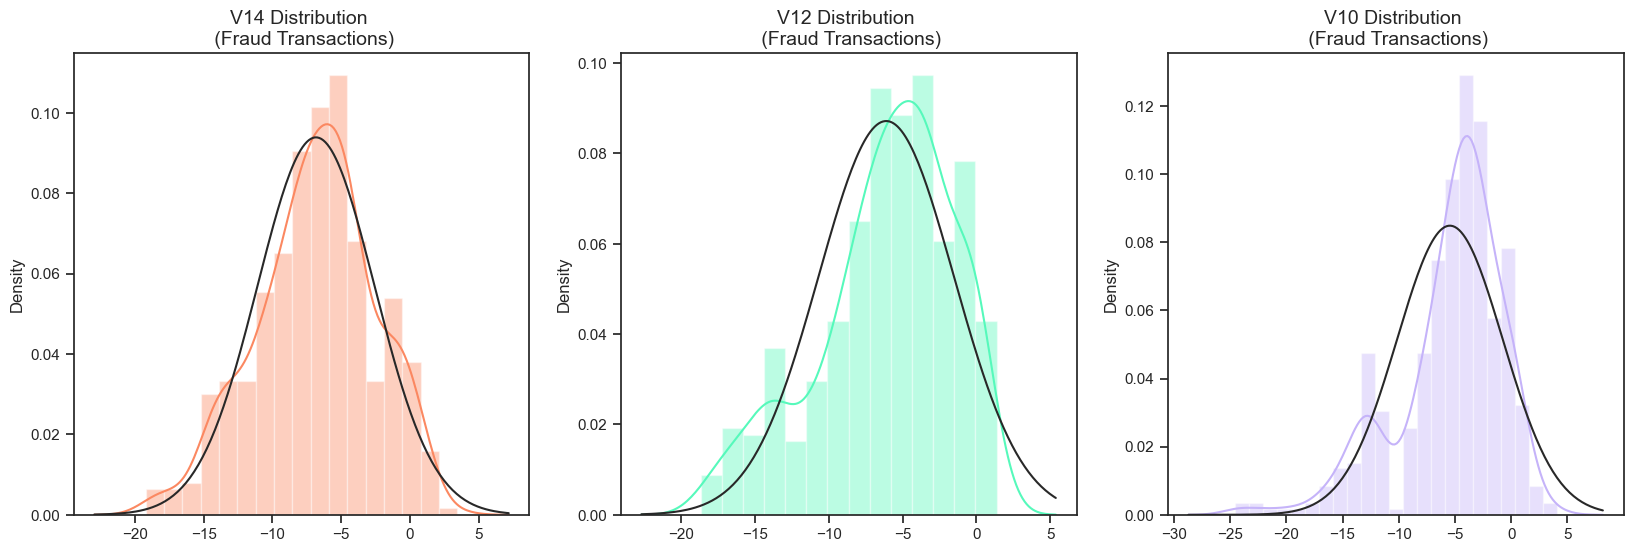

In [33]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Come determinare la soglia?

Una volta determinato il numero "cut_off" per cui moltiplicare l' IQR (qui 1.5), si determinano:

- soglia inferiore: q25 - cut_off

- soglia superiore: q75 + cut_off

Note le due soglie si procede con l'eliminazione degli outliers.

In [34]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))


new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.50514082568186 | Quartile 75: -4.25246559869278
iqr: 5.25267522698908
Cut Off: 7.87901284048362
V14 Lower: -17.38415366616548
V14 Upper: 3.62654724179084
V14 outliers:[-18.0499976898594, -17.4759212828566, -17.7216383537133, -17.6206343516773, -18.8220867423816, -18.4937733551053, -19.2143254902614]
Feature V14 Outliers for Fraud Cases: 7
Number of Instances after outliers removal: 957
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -16.971245282033493
V12 Upper: 5.672071569485119
V12 outliers: [-18.4311310279993, -18.6837146333443, -17.003289445516, -18.5536970096458, -18.0475965708216, -17.1504052507291, -17.1829184301947]
Feature V12 Outliers for Fraud Cases: 7
Number of Instances after outliers removal: 950
---------------------------------------------------------------------------------------------------------------------------

I seguenti BoxPlot consentono di visualizzare che il numero di outliers è stato notevolmente ridotto.

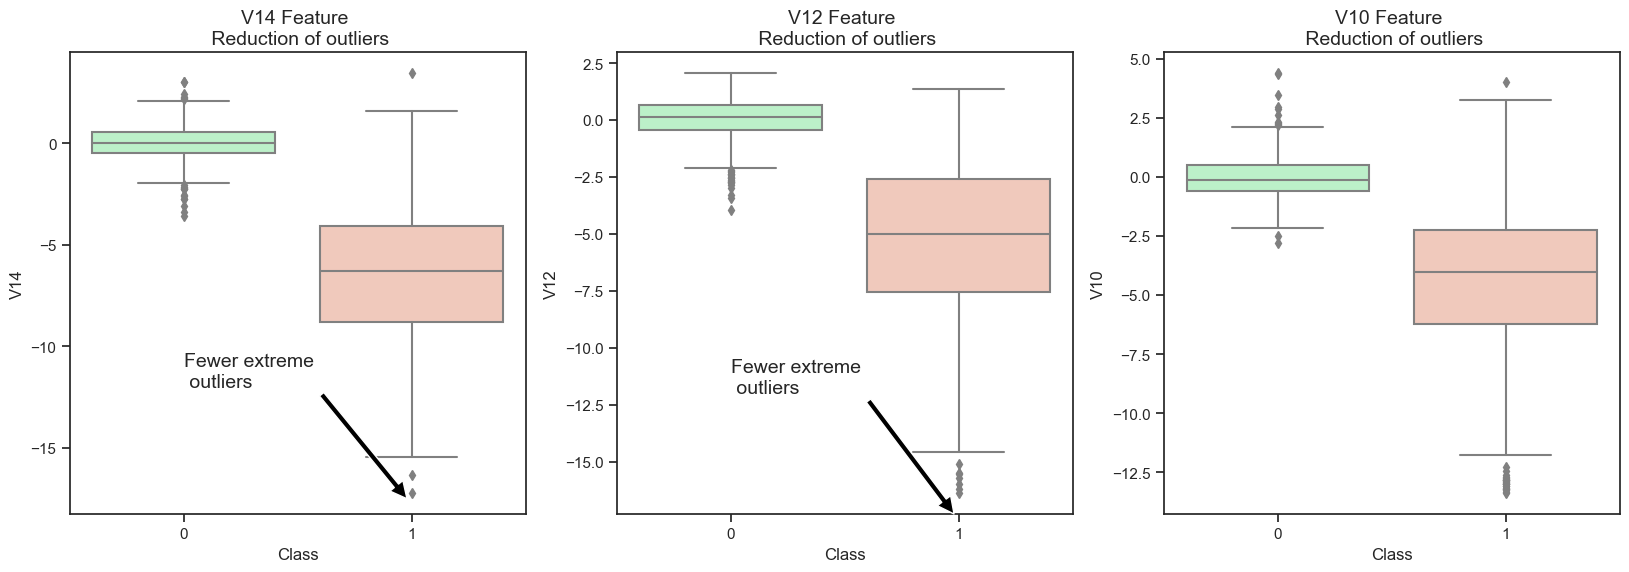

In [35]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors2 = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors2)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors2)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors2)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

Visualizzare dati in cluster

Per poter clusterizzare e quindi visualizzare le transazioni fraudolente e legittime è possibile utilizzare le tecniche di PCA e t-SNE.

PCA: tecnica non supervisionata di riduzione della dimensionalità e visualizzazione di dati a tante dimensioni. Le features sono trasformate in un nuovo insieme di vettori noti come PC, principal components. La PCA tenta di preservare la struttura globale dei dati e perciò le strutture locali potrebbero esser perse.

t-SNE: tecnica non supervisionata di riduzione della dimensionalità e visualizzazione di dati. Mappa i punti da uno spazio ad elevata dimensionalità ad uno spazio ridotto preservando i punti vicini a tale punto. A differenza della PCA prova a preservare la struttura locale minimizzando la divergenza di Kullback-Leibler. A differenza della PCA utilizza alcuni iperparametri (come la perplessità per controllare l'adattamento delle osservazioni all'algoritmo), è in grado di gestire meglio gli outliers ed è computazionalmente più onerosa in termini temporali e di memoria.

In [36]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 1.1e+01 s
PCA took 0.0087 s


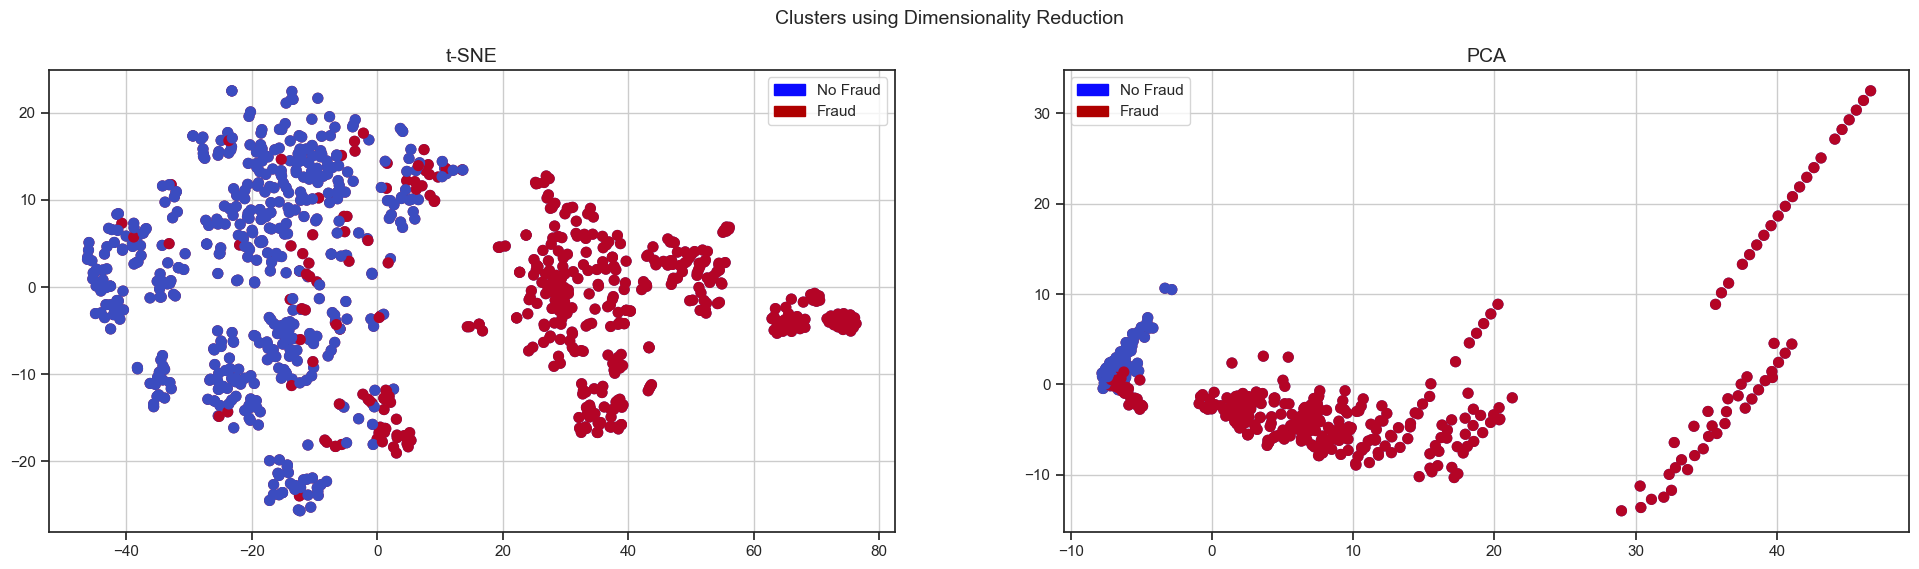

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

Sia t-SNE che PCA sono in grado di individuare dei cluster abbastanza accurati: ciò è un'indicazione di come futuri modelli predittivi possano funzionare abbastanza bene nel separare transazioni fraudolente da transazioni legittime.

Costruzione e addestramento dei classificatori

Il nostro obiettivo è ora quello di addestrare 3 tipi di classificatori e valutarne l'accuratezza nel riconoscere transazioni fraudolente. Per fare ciò dobbiamo dividere il dataset in training e test set, poi valutare i punteggi di addestramento di ogni classificatore.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import collections

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression" : LogisticRegression(),
    "KNearest" : KNeighborsClassifier(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(),
}

from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")



Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


Usiamo anche la tecnica della GridSearch per trovare la combinazione di iperparametri migliore per ciascun modello, in modo tale da massimizzare le loro prestazioni sul set di addestramento.

In [39]:
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
# Il parametro "penalty" permette di scegliere il tipo di regolarizzazione e il parametro "C" la forza della regolarizzazione
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# Otteniamo automaticamente la Logistic Regression con i migliori parametri.
log_reg = grid_log_reg.best_estimator_

# Possiamo scegliere il numero di neighbors in ogni cluster
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# DecisionTree Classifier
# Tra i parametri possiamo scegliere la profondità dell'albero (variabile)
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.2%
Knears Neighbors Cross Validation Score 92.39%
DecisionTree Classifier Cross Validation Score 91.31%


Ora bisogna effettuare la cross validation sul dataset, eseguendo contemporaneamente undersampling. Verrà implementata anche la tecnica "NearMiss": tecnica di undersampling che seleziona campioni della classe maggioritaria in base alla distanza dai campioni della classe minoritaria.

In [40]:
# Undersampling durante la cross validation
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementiamo la tecnica NearMiss
# Stampiamo la distribuzione delle classi dopo aver applicato NearMiss
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))


for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 47578  48237  48324 ... 283723 283724 283725] Test: [    0     1     2 ... 56758 56759 56760]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 47578  48237  48324 ... 113498 113499 113500]
Train: [     0      1      2 ... 283723 283724 283725] Test: [104718 105964 106503 ... 171787 173261 174327]
Train: [     0      1      2 ... 283723 283724 283725] Test: [170228 170229 170230 ... 226980 226981 226982]
Train: [     0      1      2 ... 226980 226981 226982] Test: [223728 224905 226983 ... 283723 283724 283725]
NearMiss Label Distribution: Counter({0: 473, 1: 473})


Può essere utile, ora, tracciare e analizzare le curve di appendimento dei diversi classificatori. Le curve di apprendimento mostrano come le prestazioni di un modello cambiano al variare della dimensione del set di addestramento, fornendo informazioni utili su possibili problemi di underfitting o overfitting.

Underfitting: se sia la curva di addestramento che quella di cross-validation sono basse;
Overfitting: se la curva di addestramento è alta ma quella di cross-validation è significativamente più bassa.

<module 'matplotlib.pyplot' from 'c:\\Users\\franc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

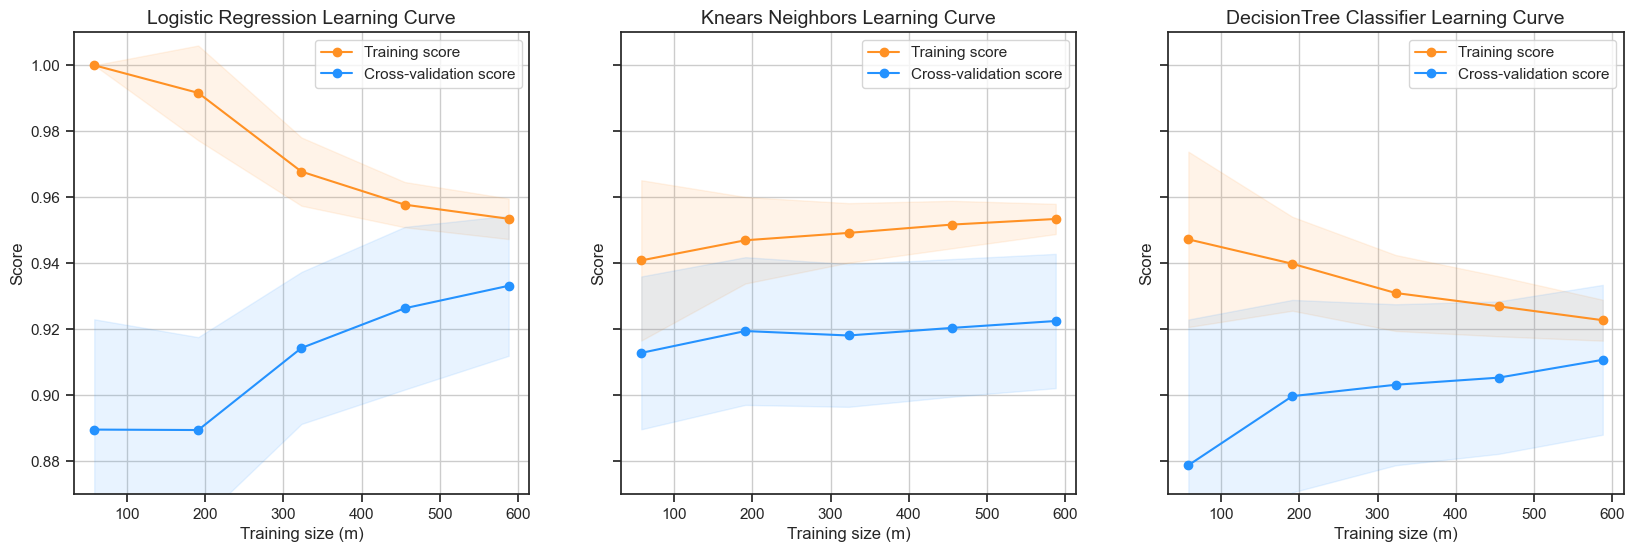

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, learning_curve

# Funzione per disegnare le curve di apprendimento con 3 stimatori
def plot_learning_curve(estimator1, estimator2, estimator3, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    
    # Primo stimatore
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Secondo stimatore
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Terzo stimatore
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax3.set_title("DecisionTree Classifier Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    return plt

# Esempio di utilizzo:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=8)


Possiamo ora costruire un dataframe con i classificatori e i relativi punteggi di classificazione.

In [42]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)


tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9675411293908402
KNears Neighbors:  0.9224988883948421
Decision Tree Classifier:  0.9101230176374685


La funzione "roc_auc_score" calcola la "Area Under Curve" rispetto ai grafici precedenti, che rappresentano lo score predittivo calcolato e a cui si è arrivati con l'andamento descritto dalle curve di apprendimento.

In particolare la curva ROC è tracciata calcolando il tasso di veri positivi (TPR) ed il tasso di falsi positivi (FPR) ad ogni soglia possibile. Un modello perfetto, che a una certa soglia ha un TPR di 1,0 e un FPR di 0,0, può essere rappresentata da un punto (0, 1).

L'area sotto la curva ROC (AUC) rappresenta la probabilità che il modello, se vengono forniti un esempio positivo e negativo scelto in modo casuale, classifica il positivo come più alto del negativo. Il modello perfetto ha una area sotto la curva (AUC) di 1.


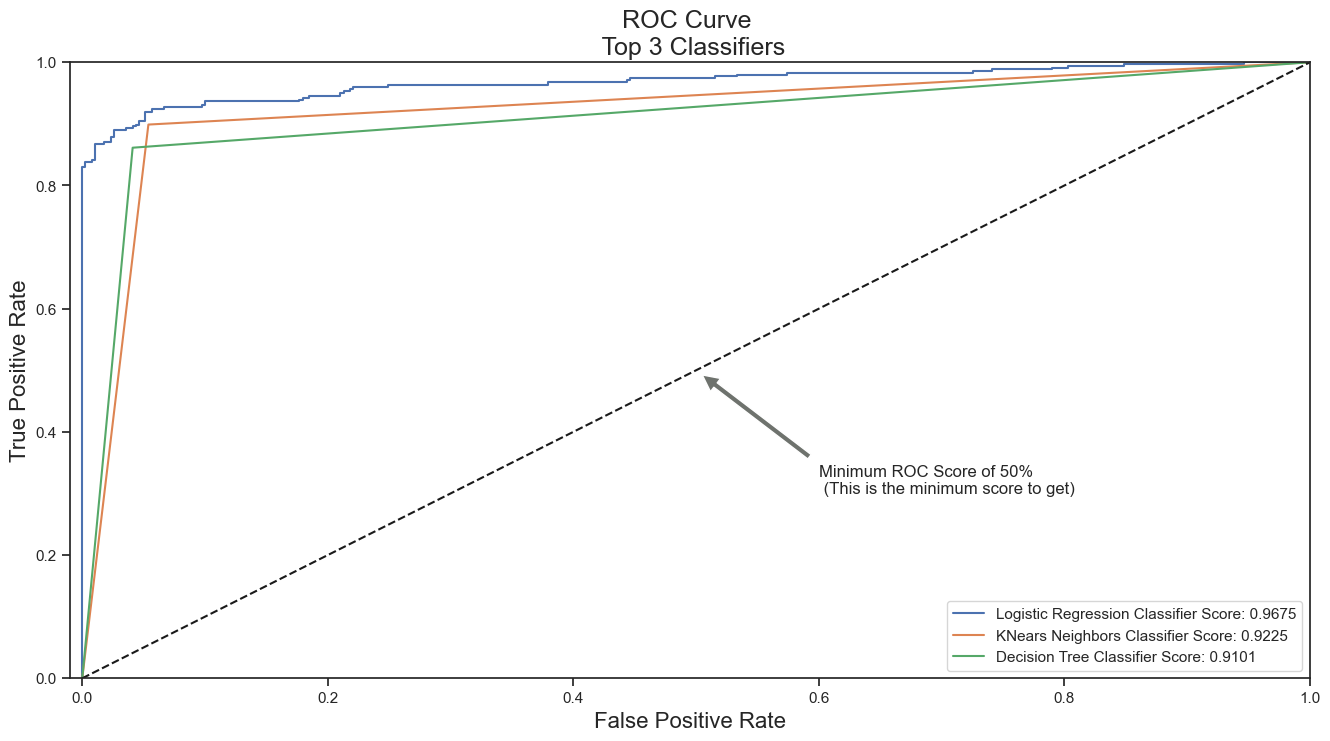

In [43]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr)
plt.show()

Osservando le curve ROC dei 3 classificatori è possibile notare come tutti e 3 abbiano ottime prestazioni, soprattutto il Classificatore Logistic Regression.

Analisi più approfondita del Logistic Regression Classifier

- True Poisitives: transazioni fraudolente correttamente classificate
- False Positives: transazioni legittime erroneamente classificate
- True Negative: transazioni legittime correttamente classificate
- False Negative: transazioni fraudolente erroneamente classificate
- Precision: True Positives/(True Positives + False Positives). Indica quanto è preciso il modello nel rilevare trasazioni fraudolente (quanto è sicuro)
- Recall: True Positives/(True Positives + False Negatives). Indica il numero di transazioni fraudolente che il modello è in grado di rilevare
- Precision/Recall Tradeoff: più il modello è selettivo e meno casi rileverà (in generale aumento la precision e si riduce la recall)
- F1 score: media armonica di precision e recall

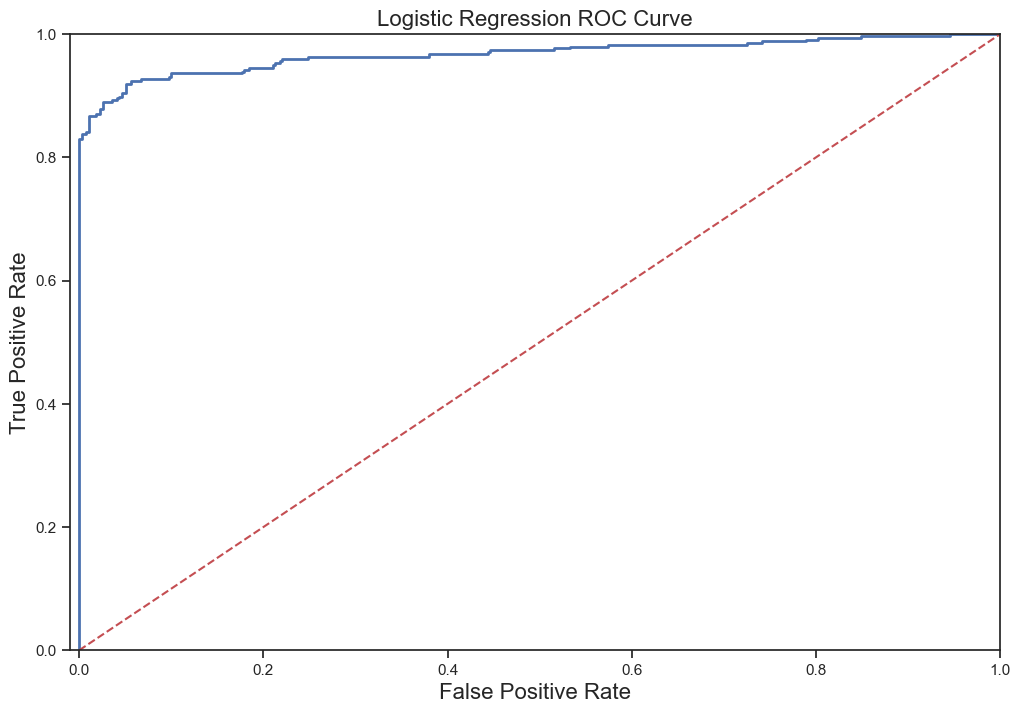

In [44]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [45]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [46]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

print('---' * 45)
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)



---------------------------------------------------------------------------------------------------------------------------------------
Recall Score: 0.94
Precision Score: 0.67
F1 Score: 0.78
Accuracy Score: 0.76
---------------------------------------------------------------------------------------------------------------------------------------


È possibile notare come si ottengano ottime prestazioni. 

SMOTE: over sampling

SMOTE sta per Synthetic Minority Over-sampling Technique e, a differenza dell'Under Sampling, crea nuovi punti sinteticamente a partire dalla classe minoritaria per avere un ugual bilanciamento tra classi (minoritaria e maggioritaria). Consente quindi di risolvere problemi con classi molto sbilanciate.

Rispetto alla tecnica di random under sampling eseguita in precedenza sono preservate più informazioni in quanto non è più necessario eliminare alcuna osservazione. Ciò comporta quindi un tempo di addestramento decisamente maggiore e, probabilmente, anche un'accuracy più alta.

Per evitare di introdurre overfitting, SMOTE è eseguito durante la cross validation e non prima (i dati sintetici sono creati solo per il training set, senza coinvolgere anche il validation set).

Effettuare l'oversampling o l'undersampling dei dati prima della cross validation andrà ad influenzare direttamente il validation set, causando un problema di "data leakage" e portando ad overfit.

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 226981 | Length of y (train): 226981
Length of X (test): 56745 | Length of y (test): 56745
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.968244221503747
precision: 0.06030638450867028
recall: 0.8913333333333334
f1: 0.11137404444968815
---------------------------------------------------------------------------------------------------------------------------------------


Come prevedibile, SMOTE consente di ottenere un'accuracy più alta rispetto alle tecniche precedenti, richiedendo però un tempo di addestramento decisamente maggiore.

Fitting oversample data took :4.661930561065674 sec


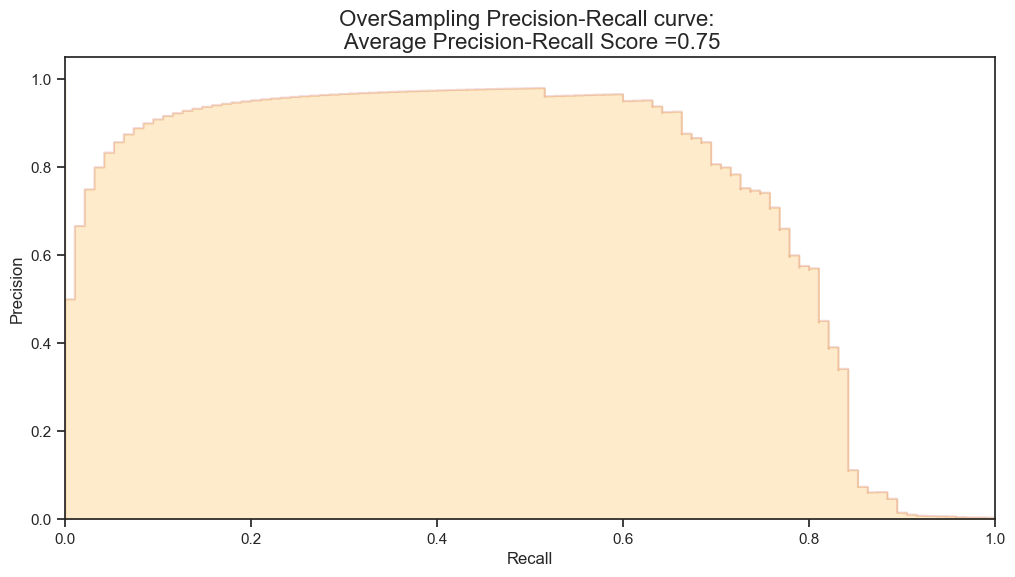

In [48]:
from sklearn.metrics import average_precision_score

y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

sm = SMOTE(random_state=42)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Questa curva ha l'andamento atteso: per recall bassa la precision è alta, per valori elevati di recall, la precision inizia a diminuire.

Analisi dei dati con la Logistic Regression

È utile ora costruire le matrici di confusione per ognuno dei tre modelli predittivi, per valutarne rapidamente l'efficacia e la qualità delle previsioni e identificarne eventuali errori ricorrenti. Ogni matrice di confusione si compone di quattro riquadri:

True Negatives (Alto-Sinistra): Numero di corrette classificazioni del "No" (No Fraud Detected).


False Negatives (Alto-Destra): Numero di errate classificazioni del "No"(No Fraud Detected).


False Positives (Basso-Sinistra): Numero di errate classificazioni del "Sì" (Fraud Detected). 


True Positives (Basso-Destra): Numero di corrette classificazioni del "Sì" (Fraud Detected).

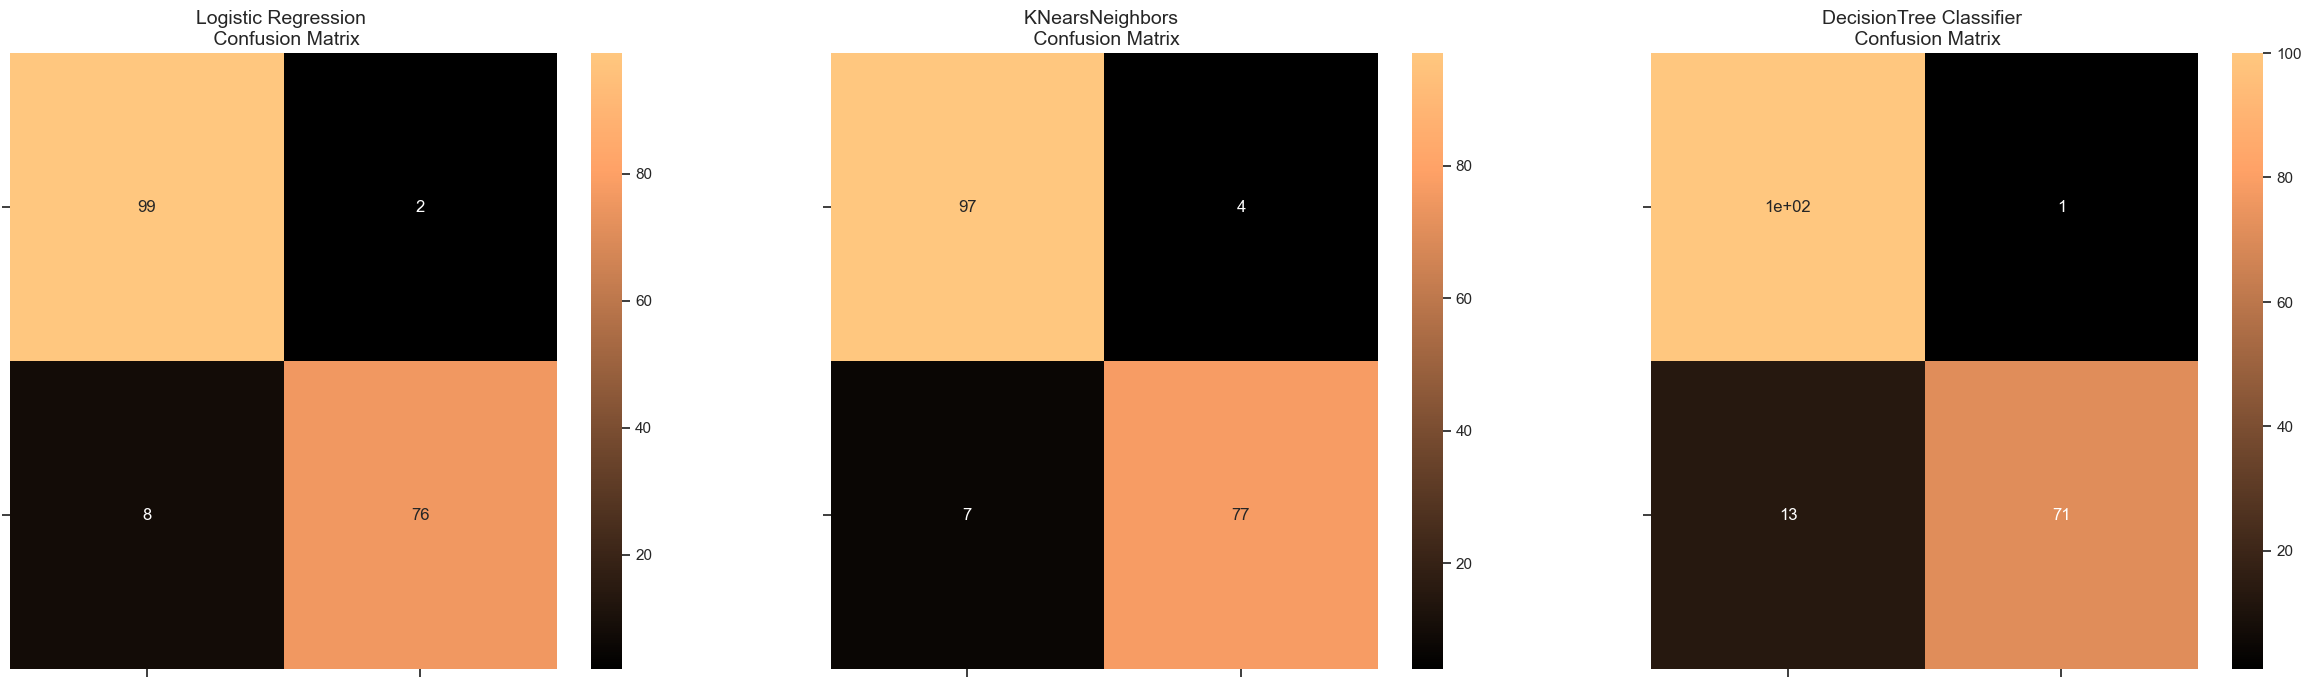

In [49]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(1,3,figsize=(30,8))


sns.heatmap(log_reg_cf, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[1], annot=True, cmap=plt.cm.copper)
ax[1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[2], annot=True, cmap=plt.cm.copper)
ax[2].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[2].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

Dalle matrici di confusione è possibile notare che: 
            1. La valutazione è stata eseguita sul sottocampione ricavato dal random undersampling;
            2. Le migliori prestazioni si sono ottenute per Logistic Regression e KNearsNeighbors.

In [50]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))
print('****************************')

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))
print('****************************')

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))
print('****************************')

Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       101
           1       0.97      0.90      0.94        84

    accuracy                           0.95       185
   macro avg       0.95      0.94      0.95       185
weighted avg       0.95      0.95      0.95       185

****************************
KNears Neighbors:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       101
           1       0.95      0.92      0.93        84

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185

****************************
Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       101
           1       0.99      0.85      0.91        84

    accuracy                           0.92       185
   ma

Fatte queste valutazioni è utile confrontare i valori dello "score" ottenuti dalla Logistic Regression con le due tecniche di Random Under-Sampling e SMOTE:

In [51]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)


score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)


final_df

,Technique,Score
0,Random UnderSampling,0.945946
1,Oversampling (SMOTE),0.987964


Reti Neurali con Random Under-Sampling e SMOTE

Per raggiungere un livello più approfondito di analisi può essere implementata una semplice rete neurale (con un solo strato nascosto) per decidere quale dei due modelli di Logistic Regression implementati finora (Random Under-Sampling o SMOTE) fornisce il miglior valore di accuracy. Per fare ciò la rete neurale sarà addestrata su entrambi i sottocampioni ricavati dalle due tecniche, per poi essere usata per predire la corretta classe di ogni transazione nel dataset originale. Per la rete neurale verrà usata la seguente struttura:

Modello di rete neurale semplice composto da un livello di input (dove il numero di nodi è uguale al numero di features) più un nodo di bias, un livello nascosto con 32 nodi e un nodo di output composto da due possibili risultati: 0 o 1 (transazione legittima o frode).

Come tasso di apprendimento useremo un valore di 0.001 e la funzione di attivazione implementata è la "ReLU" (Rectified LInear Unit). La previsione della classe verrà affettuata scegliendo la probabilità (fornita dalla funzione di loss -> "sparse categorical cross-entropy") maggiore tra i due casi possibili: "essere una transazione legittima" o "essere una frode". 

Rete Neurale e Undersampling

In [52]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy


n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [53]:
undersample_model.summary()
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [54]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest), axis=1)

1774/1774 [==============================] - 3s 2ms/step


Creiamo allora una matrice di confusione per confrontare le previsioni con e senza undersampling.

Confusion matrix, without normalization
[[55523  1127]
 [   94     1]]
Confusion matrix, without normalization
[[56650     0]
 [    0    95]]


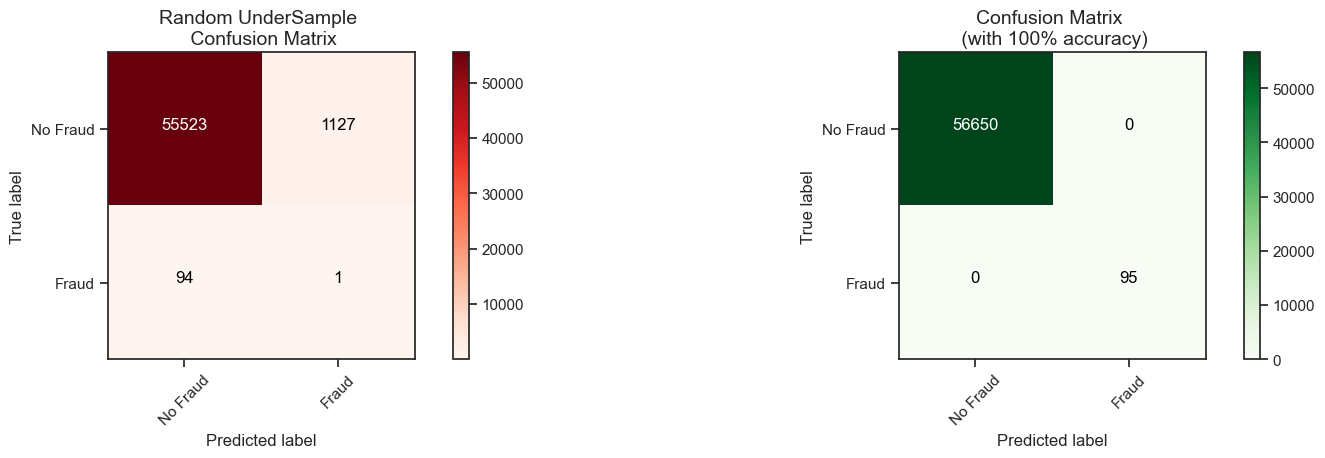

In [55]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Rete Neurale e Oversampling (SMOTE)

In [56]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [57]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1209/1209 - 5s - loss: 0.0602 - accuracy: 0.9789 - val_loss: 0.0206 - val_accuracy: 0.9958 - 5s/epoch - 4ms/step
Epoch 2/20
1209/1209 - 4s - loss: 0.0116 - accuracy: 0.9974 - val_loss: 0.0073 - val_accuracy: 0.9998 - 4s/epoch - 3ms/step
Epoch 3/20
1209/1209 - 3s - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.0049 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 4/20
1209/1209 - 3s - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 0.9998 - 3s/epoch - 3ms/step
Epoch 5/20
1209/1209 - 4s - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0017 - val_accuracy: 1.0000 - 4s/epoch - 4ms/step
Epoch 6/20
1209/1209 - 3s - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0010 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 7/20
1209/1209 - 4s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 1.0000 - 4s/epoch - 3ms/step
Epoch 8/20
1209/1209 - 4s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000 - 4s/epoch - 3ms/step
Epoch 9/

1774/1774 [==============================] - 3s 2ms/step
Confusion matrix, without normalization
[[55523  1127]
 [   94     1]]
Confusion matrix, without normalization
[[56650     0]
 [    0    95]]


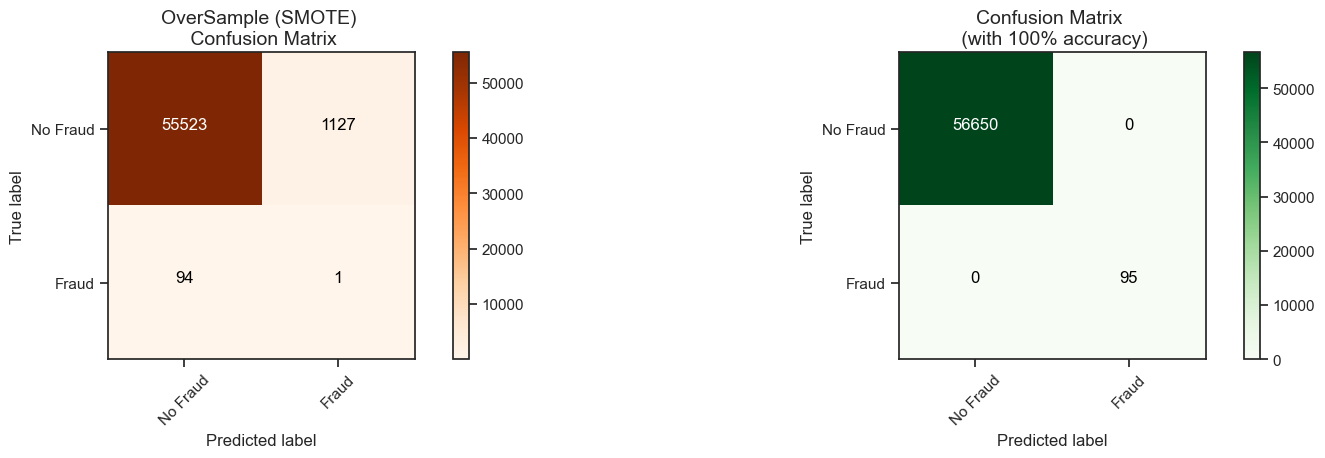

In [59]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest), axis=1)
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)